# Injected waveform overview
This is a notebook to produce BNS waveforms.

## Prerequisites

### PyCBC

For the purposes of this notebook, we use the **PyCBC** package. It is useful to analyze gravitational-wave data! You can find out more by visit its [github page](https://github.com/gwastro/pycbc) or its [web-page](https://pycbc.org/). Also, you can try out their [tutorials](https://github.com/gwastro/PyCBC-Tutorials) (including a good  [video by Collin Capano](https://icerm.brown.edu/video_archive/?play=2407)) without installing the package.

In [ ]:
#!pip install pycbc

**Importing required modules...**

In [2]:
####################################### Some basic imports ###############################
import sys

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

rcparams = {
          'axes.labelsize': 10,
          'font.size': 8,
          'font.family': 'Times New Roman',
          'font.sans-serif': 'Bitstream Vera Sans',
          'legend.fontsize': 10,
          'xtick.color': 'k',
          'xtick.labelsize': 8,
          'ytick.color': 'k',
          'ytick.labelsize': 8,
          'text.usetex': True,
          'text.color': 'k',
          'figure.figsize': [4.4, 3.1],
          'figure.dpi': 150,
          }
import numpy as np

############################################################################################
from pycbc.detector import Detector

## Waveform Overview

#### Antenna pattern

Based on the papers [Shutz (2011)](https://arxiv.org/pdf/1102.5421.pdf) and [Anderson et al (2001) - "Appendix B"](https://arxiv.org/pdf/gr-qc/0008066.pdf).


Each detector is linearly polarized and has a quadrupolar antenna pattern. In the notation of [Sathyaprakash and Schutz (2009)](https://arxiv.org/pdf/0903.0338.pdf), they consider a detector in the x − y plane with arms along the axes (in terms of latitude and longitude {$\phi, \lambda$}, the coordinate axes are oriented so that the x-axis pierces the earth at {000, 000}, the y-axis pierces the earth at {$000, 090 ^{\circ}E$}, and the z-axis pierces the earth at {$090 ^{\circ} N, 000$}), and a gravitational wave coming from a direction given by the usual spherical polar coordinates $\theta$ and $\phi$ relative to the detector’s axes, whose two polarization components $h_+$ and $h_\times$ are referred to axes in the plane of the sky that are rotated by an angle $\psi$ relative to the detector axes (see figure 3 of Sathyaprakash and Schutz, 2009).

Then, the antenna pattern response functions of the interferometer to the two polarizations of the wave as defined in the sky plane:

$$F_+=-\frac{1}{2}\big(1+\cos^2\theta\big)\cos2\phi \cos2\psi-\cos\theta\sin2\phi \sin2\psi$$
$$F_\times=\frac{1}{2}\big(1+\cos^2\theta\big)\cos2\phi \cos2\psi+\cos\theta\sin2\phi \sin2\psi$$


A fiducial signal s comes from a sky position with right ascension $\alpha = \phi$ + GMST (GMST is the Greenwich mean sidereal time of arrival of the signal), declination $\delta = \pi/2 − \theta$, and has polarization angle $\psi$—the angle (counter-clockwise about the direction of propagation) from the line of nodes to the X-axis
of the signal coordinates.

In this concept is based the package ```pyCBC```, from which someone can obtain the detector responses by importing the class ```Detector``` from ```pycbc.detector``` and then calling the function ```antenna_pattern(right_ascension, declination, polarization, t_gps)```. 

### **Optimal sky-location for a given gps time**


The module ```optimal_orientation``` from ```pycbc.detector``` returns the **optimal orientantion** of the source for a given gps time and detector

In [3]:
# gps time (BayesWave input) or trigger time of the event
gps_time = 1186969282.43 # 1187008882.43 GW170817

# detectors
detector = {'H1':'h','L1':'l','V1':'v'}

# get Detector instance for IFO
ifo = 'L1'
det = Detector(ifo)

ra, dec = det.optimal_orientation(gps_time)
while ra < 0:
    ra += 2 * np.pi
print(ra,dec)

4.540198047967529 0.5334231350225018


Example of the antenna pattern functions for an optimal oriented source:

In [4]:
polarization = 0

fp, fc = det.antenna_pattern(ra, dec, polarization, gps_time)

print(fp, fc)

0.814793835285605 -0.5797504226609747


### Effective distance

The effective distance of the source scales the distance so that the amplitude is equal to a source which is optimally oriented with respect to the detector. For fixed detector-frame intrinsic parameters this is a measure of the expected signal strength.

Thus, the **effective distance** ($d_{eff}$) **equals the physical distance** if the binary is seen **face-on**, and is at the detector’s zenith or nadir [(see more - Whelan, 2013)](https://dcc.ligo.org/public/0106/T1300666/003/Whelan_geometry.pdf).

**How can someone compute the effective distance?**

Assuming the low-inspiral approximation and after some calculations, we see that the overall amplitude is determined by the distance to the source

$$h(t)=\frac{A(t)}{d}\bigg(\sqrt{F^2_+\frac{(1+\cos{\iota})^2}{4}+F^2_{\times}\cos^2\iota}\bigg)\cos[\Phi(t)+\Psi]$$

that distance appears together with the observing geometry in a combination known as *effective distance*

$$d_{eff}=\frac{d}{\sqrt{F^2_+\frac{(1+\cos{\iota})^2}{4}+F^2_{\times}\cos^2\iota}}$$

where 
* $F_+, F_{\times}$ are the antenna pattern factors, 

* d the physical distance of the source, 

* $\iota$ the inclination, 

* A(t) the amplitude, 

* $\Phi(t)=2\Omega(t-d/c)$,

* t-d/c indicates that the observer is seeing the source as it was at a time in the past, when the gravitational waves now reaching the observer were emitted,

* $\Omega$ is the angular speed

* and $\Psi$ the phase between the terms $F_+\frac{(1+\cos{\iota})}{2}$ and $F_{\times}\cos\iota$


Note that the factor in the square root is a maximum (and therefore the effective distance corresponding to a given physical distance) when $|\cos\iota| = 1$, i.e., we are seeing the binary face on ($\iota = 0$ or  $\iota= \pi$).

Considering the above-mentioned relation for the effective distance and making the assumption that the $|\cos\iota| = 1$, then the term $F^2_+ + F^2_{\times}\le1$ and thus $d_{eff}\ge d$

In [5]:
def effective_distance(distance, inclination, fp, fc):
    cplus = fp**2 * ( 1 + np.cos( inclination )**2 )**2/ 4 
    ccross = fc**2 * np.cos( inclination )**2 
    denominator = np.sqrt(cplus + ccross)
    return distance / denominator

Let's say that our source is estimated to be at 5Mpc. If the source isn't optimally oriented with respect to the detector, the effective distance is

In [6]:
print(effective_distance(5, -np.pi/2, fp, fc))

12.273043274185742


Some tests for that cases (by changing the inclination):

In [7]:
# get Detector instance for IFO
det = Detector(ifo)

i=0
while i<=2*np.pi:
    polarization = i 

    # get time delay to detector from center of the Earth
    time_delay = det.time_delay_from_earth_center(ra, dec, gps_time)
    local_time = gps_time + time_delay
    
    # get antenna pattern
    fp, fc = det.antenna_pattern(ra, dec, polarization, local_time)

    print(i, effective_distance(5, np.pi/2, fp, fc))
    i+=0.1

0 12.273029518129151
0.1 14.633259907401083
0.2 19.058120530507857
0.30000000000000004 28.974745683857236
0.4 65.88205875421083
0.5 210.05491979298532
0.6 40.79939693401914
0.7 23.104010026520108
0.7999999999999999 16.57567853871292
0.8999999999999999 13.338483783746184
0.9999999999999999 11.54416270433148
1.0999999999999999 10.545934404964456
1.2 10.076341138423468
1.3 10.02958795907729
1.4000000000000001 10.395800273487694
1.5000000000000002 11.255495475591456
1.6000000000000003 12.827699927147309
1.7000000000000004 15.634958580485135
1.8000000000000005 21.091564280348475
1.9000000000000006 34.512242485724705
2.0000000000000004 106.57595521290767
2.1000000000000005 94.48816436454722
2.2000000000000006 33.192015627110386
2.3000000000000007 20.630883602679113
2.400000000000001 15.41261212463932
2.500000000000001 12.705479662405223
2.600000000000001 11.18659578240407
2.700000000000001 10.361041167052393
2.800000000000001 10.021011107342217
2.9000000000000012 10.092147711309496
3.0000000

In [8]:
# There are some blind spots 45/-45 deg -> https://core.ac.uk/download/pdf/11814199.pdf
polarization = 5.19
# get antenna pattern
# get time delay to detector from center of the Earth
time_delay = det.time_delay_from_earth_center(ra, dec, gps_time)
local_time = gps_time #+ time_delay

fp, fc = det.antenna_pattern(ra, dec, polarization, local_time)

effective_distance(5, np.pi/2, fp, fc)

3510.9656280100303

However, if the inclination is optimal (face-on) case, we can get almost the physical distance for each polarization

In [9]:
# get Detector instance for IFO
det = Detector(ifo)

i=0
while i<=2*np.pi:
    polarization = i 
# get antenna pattern
# get time delay to detector from center of the Earth
    time_delay = det.time_delay_from_earth_center(ra, dec, gps_time)
    local_time = gps_time + time_delay

    fp, fc = det.antenna_pattern(ra, dec, polarization, local_time)


    print(i, effective_distance(5, np.pi, fp, fc))
    i+=0.1

0 5.000001134261159
0.1 5.000001134261158
0.2 5.000001134261159
0.30000000000000004 5.00000113426116
0.4 5.00000113426116
0.5 5.000001134261159
0.6 5.000001134261159
0.7 5.00000113426116
0.7999999999999999 5.00000113426116
0.8999999999999999 5.000001134261159
0.9999999999999999 5.0000011342611606
1.0999999999999999 5.00000113426116
1.2 5.0000011342611606
1.3 5.000001134261159
1.4000000000000001 5.000001134261159
1.5000000000000002 5.000001134261159
1.6000000000000003 5.000001134261159
1.7000000000000004 5.0000011342611606
1.8000000000000005 5.000001134261159
1.9000000000000006 5.000001134261159
2.0000000000000004 5.000001134261159
2.1000000000000005 5.00000113426116
2.2000000000000006 5.000001134261159
2.3000000000000007 5.00000113426116
2.400000000000001 5.00000113426116
2.500000000000001 5.000001134261159
2.600000000000001 5.000001134261159
2.700000000000001 5.000001134261159
2.800000000000001 5.00000113426116
2.9000000000000012 5.00000113426116
3.0000000000000013 5.000001134261159
3

### Constructing the strain

**Strain $\sigma(t)$**

The strain $\delta L/L$ of the interferometer is (see eq.55 from [Sathyaprakash and Schutz, 2009](https://arxiv.org/pdf/0903.0338.pdf)):

$$\sigma (t) = F_+h_+ + F_{\times}h_{\times}$$

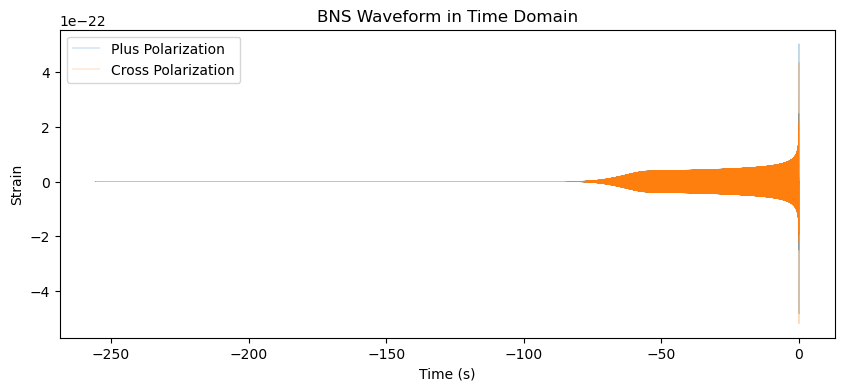

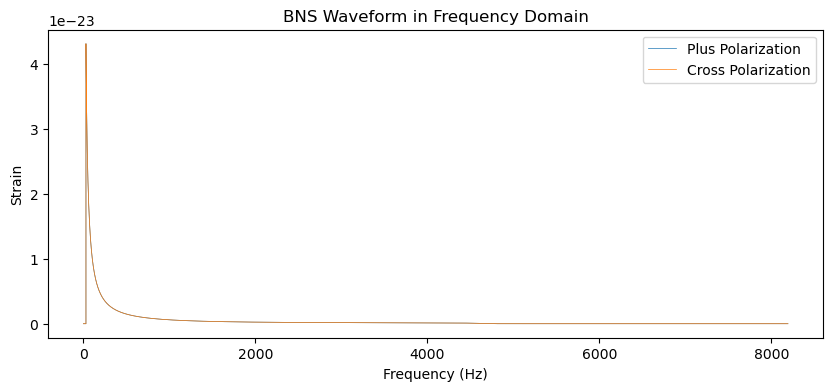

In [22]:
from pycbc.waveform import get_td_waveform, get_fd_waveform

# Define parameters for the BNS system
mass1 = 1.4  # Mass of the first neutron star in solar masses
mass2 = 1.4  # Mass of the second neutron star in solar masses
distance = 40  # Distance to the binary in megaparsecs
inclination = 0  # Inclination angle in radians
coa_phase = 0  # Coalescence phase in radians
delta_t = 1.0 / 4096  # Time step in seconds
f_lower = 30  # Lower frequency cutoff in Hz
delta_f = 1.0 / 32  # Frequency step in Hz

# Generate the waveform in time domain
hp_td, hc_td = get_td_waveform(approximant="IMRPhenomD_NRTidal",
                               mass1=mass1,
                               mass2=mass2,
                               distance=distance,
                               inclination=inclination,
                               coa_phase=coa_phase,
                               delta_t=delta_t,
                               f_lower=f_lower)

# Generate the waveform in frequency domain
hp_fd, hc_fd = get_fd_waveform(approximant="IMRPhenomD_NRTidal",
                               mass1=mass1,
                               mass2=mass2,
                               distance=distance,
                               inclination=inclination,
                               coa_phase=coa_phase,
                               delta_f=delta_f,
                               f_lower=f_lower)

# Plot the waveform in time domain
plt.figure(figsize=(10, 4))
plt.plot(hp_td.sample_times, hp_td, label='Plus Polarization', lw=0.2)
plt.plot(hc_td.sample_times, hc_td, label='Cross Polarization', lw=0.2)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.title('BNS Waveform in Time Domain')
plt.show()

# Plot the waveform in frequency domain
plt.figure(figsize=(10, 4))
plt.plot(hp_fd.sample_frequencies, abs(hp_fd), label='Plus Polarization', lw=0.5)
plt.plot(hc_fd.sample_frequencies, abs(hc_fd), label='Cross Polarization', lw=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.legend()
plt.title('BNS Waveform in Frequency Domain')
plt.show()

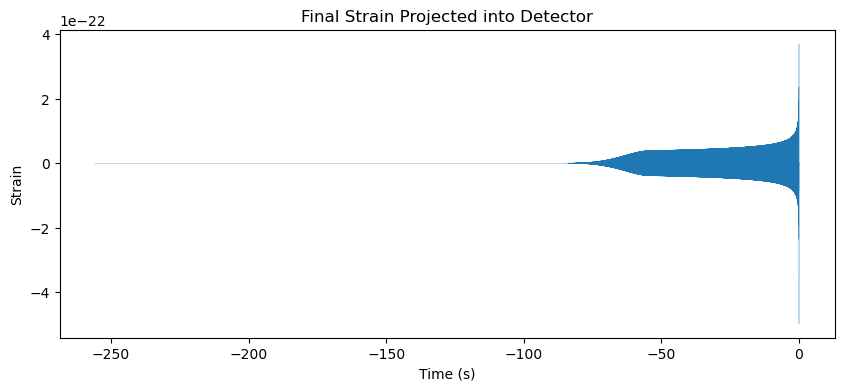

In [24]:
def get_detector_strain(ifo, ra, dec, polarization, gps_time, hp, hc):
    # get Detector instance for IFO
    det = Detector(ifo)
    
    # get time delay to detector from center of the Earth
    time_delay = det.time_delay_from_earth_center(ra, dec, gps_time)
    local_time = gps_time + time_delay

    # get antenna pattern
    fp, fc = det.antenna_pattern(ra, dec, polarization, local_time)
    
    # calculate strain
    strain = fp*hp + fc*hc
        
    return strain

# Calculate the final strain by projecting the waveform into the detector
final_strain = get_detector_strain(ifo, ra, dec, polarization, gps_time, hp_td, hc_td)

# Plot the final strain
plt.figure(figsize=(10, 4))
plt.plot(final_strain.sample_times, final_strain, lw=0.2)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Final Strain Projected into Detector')
plt.show()

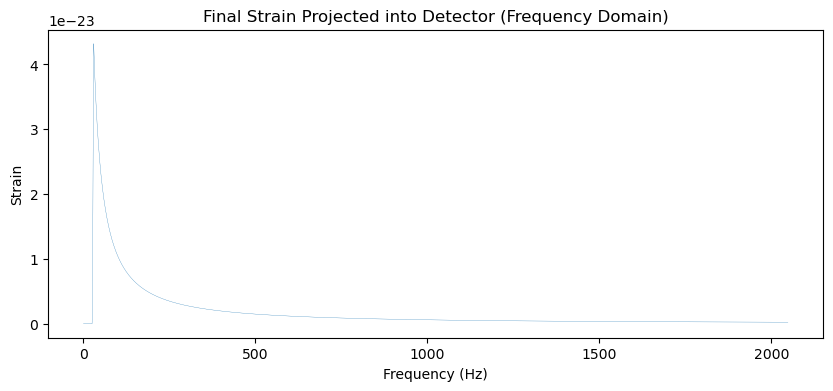

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(final_strain.to_frequencyseries().sample_frequencies, abs(final_strain.to_frequencyseries()), lw=0.2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.title('Final Strain Projected into Detector (Frequency Domain)')
plt.show()